**Author: Bosley Boka**

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Allows plots to be rendered inside the notebook
%matplotlib inline

In [6]:
# Load files
sis_data = pd.read_csv('./resources/sample_sis.csv')
assessment_data = pd.read_csv('./resources/sample_assessment.csv')
usage_data = pd.read_csv('./resources/sample_usage.csv')

# Create list of dataframes for ease of programming
dataframes = [("SIS Data", sis_data), ("Assessment Data", assessment_data), ("Usage Data", usage_data)]

In [7]:
# Normalize Headers
custom_mappings = {
    'lesson_completed': 'lessons_completed',
    'id': 'student_id'
}

for name, df in dataframes:
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_').str.replace(r'[^\w]', '')
    if custom_mappings:
        df.rename(columns=custom_mappings, inplace=True)

In [8]:
# Split Assessment Data
assessment_ela = assessment_data[assessment_data['subject'] == 'ELA']
assessment_math = assessment_data[assessment_data['subject'] == 'Math']

# Create Data Structures

# List of new math dataframes for ease of programming
math_dataframes = [("SIS Data", sis_data), ("Assessment Math Data", assessment_math), ("Usage Data", usage_data)]

# Lists of IDs
assessment_math_ids = np.array(assessment_math['student_id'])
assessment_ela_ids = np.array(assessment_ela['student_id'])
usage_ids = np.array(usage_data['student_id'])
sis_ids = np.array(sis_data['student_id'])
sis_assess_intersect_ids = np.intersect1d(sis_ids, assessment_math_ids)
all_intersecting_ids = np.intersect1d(sis_assess_intersect_ids, usage_ids)

# Report Overview
This report illustrates the data findings from cleaning, merging, and analyzing the data for the Student Math Data Project. For additional details, code, and processes used to obtain this reporting, see Student-Math-Data-Analysis-Workbook that was provided with this report.

# Data Observation Overview

## Header Notes
- While the Usage & SIS files have a clearly labeled student_id column, the Assessment file's student_id column is labeled "id".
- File headers have inconsistent formats- spacing vs underscores, mixed casing, includes slash character.
- The instructions require “lessons completed”, whereas the column header is “lesson completed”.
- The merged file column "score" was changed to "math_score" for clarity.

## Value Notes
- Benchmark level columns have inconsistent value of "Level4", i.e. no spacing.
- Duplicate student_id values exist in Assessment data, but this is expected since it includes both Math and ELA scores.
  - No duplicates exist after removing ELA subject rows.
- Assessment data column total_minutes has
  - 4 high value outliers
  - 3 values between 0 and 1, showing that 3 students completed between 14-23 lessons in under 1 minute. This may indicate a bug in the product software or in the data collection process.

In [5]:
def get_outliers_and_issues(df):
    result_rows = pd.DataFrame()
    
    for column in df.select_dtypes(include=['number']).columns:
        col_data = df[column]
        
        # Calculate IQR for outlier detection
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify rows with issues
        issues = df[(col_data < lower_bound) | 
                    (col_data > upper_bound) | 
                    (col_data == 0) | 
                    (col_data < 0) |
                    (col_data < 1)]
        
        # Add a column to indicate which issue was detected
        issues = issues.copy()  # Avoid SettingWithCopyWarning
        issues['issue_column'] = column  # Column with the detected issue
        
        result_rows = pd.concat([result_rows, issues])
    
    # Remove duplicates in case multiple columns flagged the same row
    return result_rows.drop_duplicates()

# Example Usage
outlier_rows = get_outliers_and_issues(usage_data)
outlier_rows

,student_id,lesson completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes,issue_column
16,1254138,12,level4,level 3,level 1,level 3,255.231657,total_minutes
24,1254393,16,level 2,level 2,level 1,level 1,0.167026,total_minutes
69,1254280,4,level 1,level 2,level 1,level 1,261.391669,total_minutes
154,1254252,9,level 3,level 3,level 2,level4,247.638391,total_minutes
171,1254367,13,level4,level 3,level 2,level 2,280.517175,total_minutes
179,1254255,14,level 2,level 3,level4,level 1,0.865787,total_minutes
261,1254284,23,level 3,level 2,level4,level 3,0.856146,total_minutes


## Missing Data
- 47 NaN values present in SIS data column race_ethnicity.
- 114 NaN values present in SIS data column Free/Reduced Price Lunch.
- 8 rows in Usage data don't exist in SIS data. Not included in final CSV (see below)

In [9]:
# List Missing Data (ID's in Usage but not in SIS)
missing_usage_ids = np.setdiff1d(usage_ids, sis_ids)
missing_usage_data = usage_data[usage_data['student_id'].isin(missing_usage_ids)]
missing_usage_data

,student_id,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes
40,1254070,7,level4,level 3,level 1,level4,134.195032
46,1254069,23,level4,level 2,level 3,level 1,59.247430
77,1254065,5,level4,level 3,level 1,level4,124.325568
144,1254072,24,level 1,level 3,level 1,level 3,129.205541
200,1254068,18,level 3,level 3,level4,level 1,5.879212
221,1254066,16,level 1,level 1,level4,level 3,12.492581
263,1254067,4,level 2,level4,level 2,level 2,63.419238
309,1254071,14,level 2,level 3,level4,level 2,228.975415


## Additional Observations
- IDs in Assessment but not in SIS: 0
- IDs in Usage but not in SIS: 8
- IDs in SIS but not in Assessment: 143
- IDs in SIS but not in Usage: 442
- IDs that exist in all files: 231

# Data Analysis of Merged File

In [15]:
# Load Data
final_csv = pd.read_csv('./resources/final_cleaned_data.csv')

# Convert columns back to int64 Data Type
final_csv['lessons_completed'] = final_csv['lessons_completed'].astype('Int64')
final_csv['math_score'] = final_csv['math_score'].astype('Int64')

# Create Data Structures
# Setup
demographics = ['grade_level', 'race_ethnicity', 'gender', 'free_reduced_price_lunch']
missingness_columns = ['lessons_completed', 'math_score']

## Analyze Missing Data
- Most Null/NaN values are from the Usage File, as is shown by the table and heatmap below. Columns lessons_completed and total_minutes are from Usage File.

In [16]:
null_summary = final_csv.isnull().sum().reset_index()
null_summary.columns = ['Column', 'Null Count']
null_summary['Null Percentage'] = (null_summary['Null Count'] / len(final_csv)) * 100
null_summary

,Column,Null Count,Null Percentage
0,student_id,0,0.000000
1,grade_level,0,0.000000
2,race_ethnicity,47,6.002554
3,gender,0,0.000000
4,free_reduced_price_lunch,114,14.559387
5,lessons_completed,442,56.449553
6,total_minutes,442,56.449553
7,math_score,143,18.263091


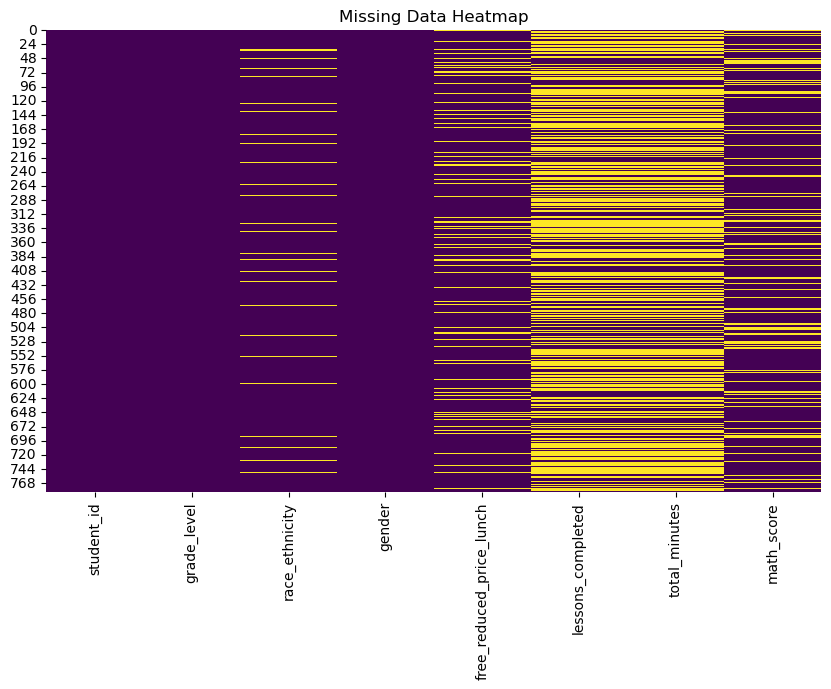

In [17]:
plt.figure(figsize=(10, 6))
sb.heatmap(final_csv.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

- The demographics with the highest missing data with respect to proportion:
  - Hispanic/Latino missing Usage Data (i.e. lessons_completed and total_minutes).
  - Two or More Races missing Assessment Data (i.e. math_score).
  - All other demographics are normal.

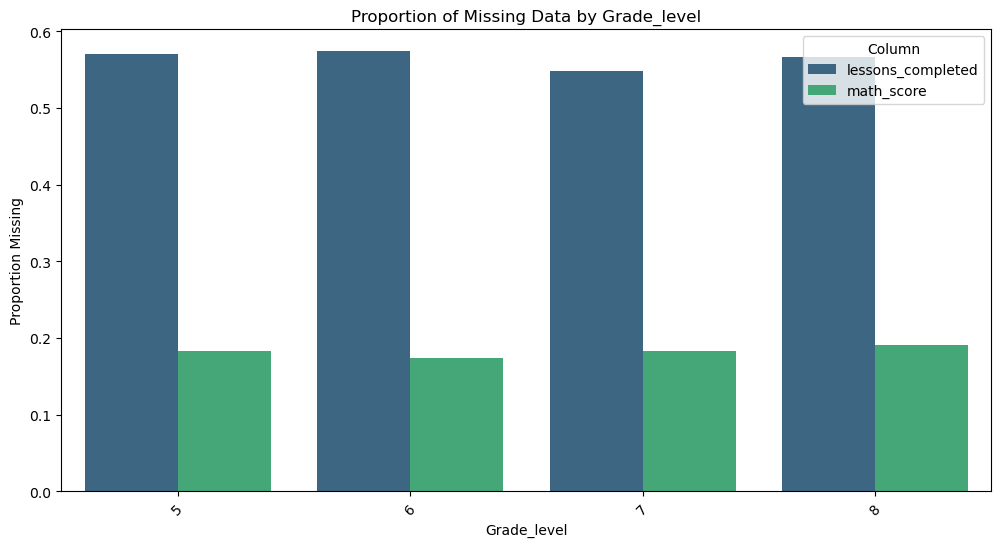

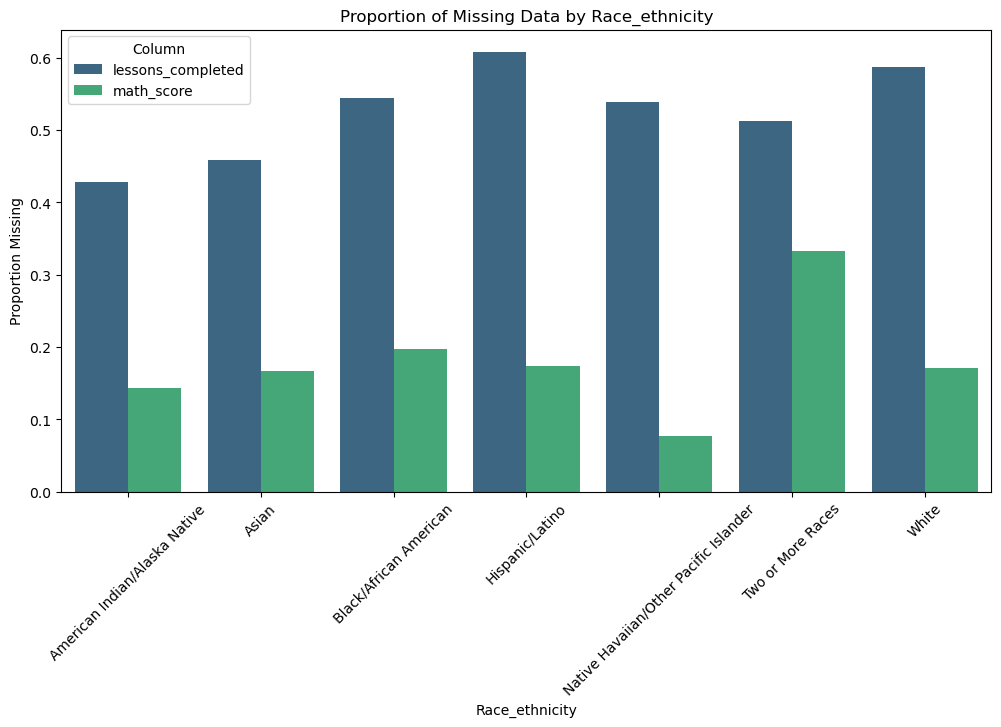

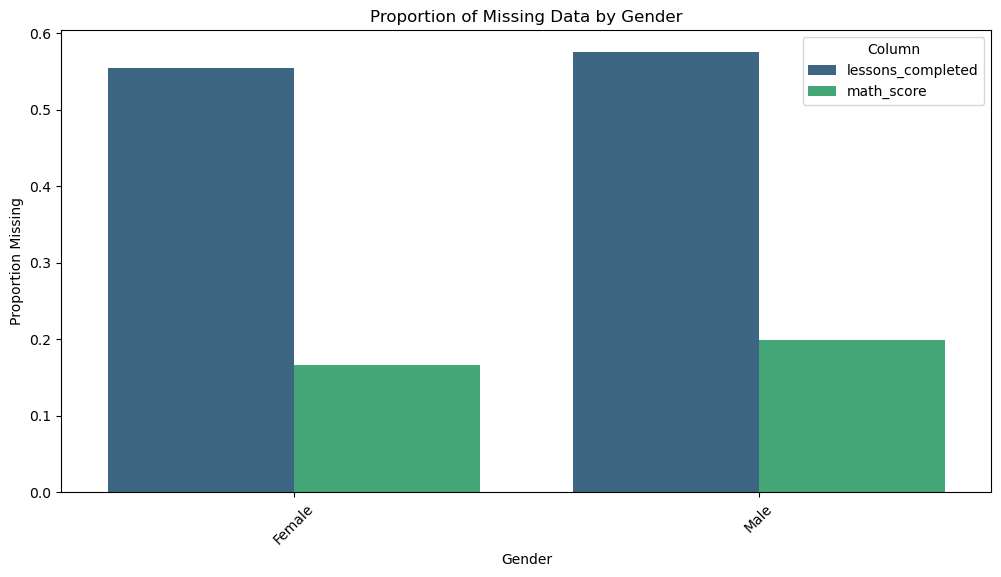

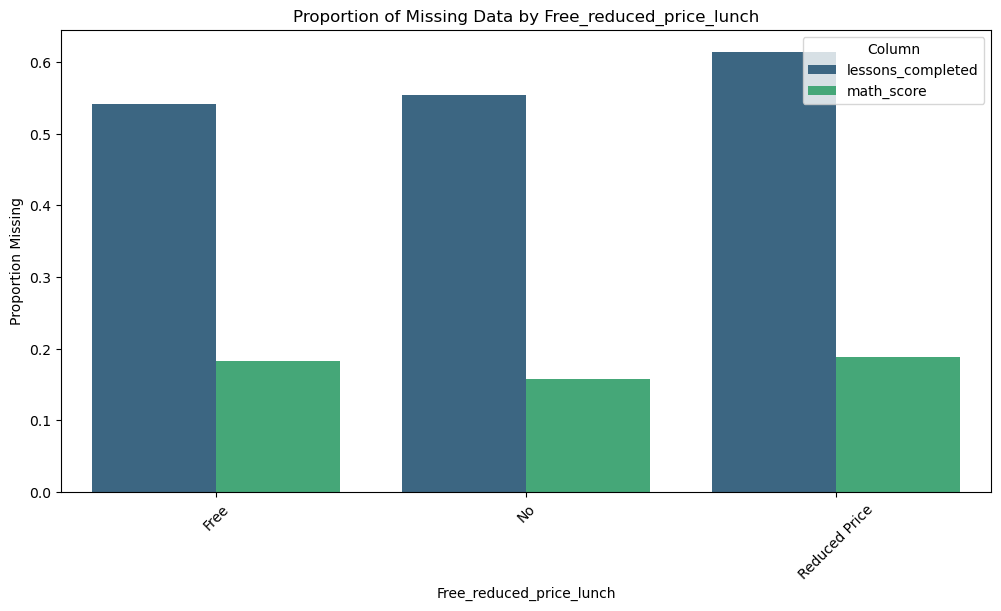

In [18]:
for demo_col in demographics:
    # Calculate proportions for missing values
    proportions = (
        final_csv.groupby(demo_col)[missingness_columns]
        .apply(lambda x: x.isnull().mean())
        .reset_index()
        .melt(id_vars=demo_col, var_name='Column', value_name='Proportion Missing')
    )
    
    # Plot the proportions
    plt.figure(figsize=(12, 6))
    sb.barplot(
        x=demo_col, 
        y='Proportion Missing', 
        hue='Column', 
        data=proportions,
        palette="viridis"
    )
    plt.title(f"Proportion of Missing Data by {demo_col.capitalize()}")
    plt.xlabel(demo_col.capitalize())
    plt.ylabel("Proportion Missing")
    plt.xticks(rotation=45)
    plt.legend(title="Column")
    plt.show()


## Analyze Math Data
- There doesn't seem to be any correlation between the math product usage and higher assessment scores. If anything, scores lower as the product is used, as is shown with the illustration below.

In [23]:
# Correlations
for col in ['lessons_completed', 'total_minutes']:
    print(f"Correlation with Score for {col}: {final_csv[col].corr(final_csv['math_score'])}")

Correlation with Score for lessons_completed: -0.16664187473992423
Correlation with Score for total_minutes: 0.1072420936688609


In [20]:
math_data = final_csv.copy()

# Fill NaN in lessons_completed and total_minutes with 0
math_data['lessons_completed'].fillna(0);
math_data['total_minutes'].fillna(0);

# Fill NaN in score with -1 to indicate no assessment taken
math_data['math_score'].fillna(-1);

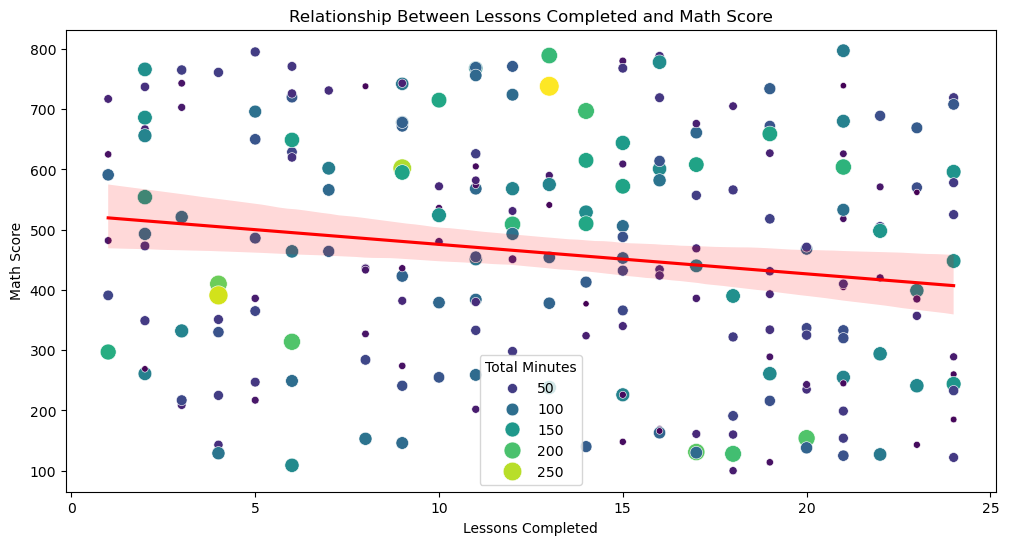

In [22]:
# Filter out rows where math_score = -1 (imputed value for missing scores)
filtered_df = final_csv[final_csv['math_score'] != -1]

# Scatter plot for lessons_completed vs math_score, colored by total_minutes
plt.figure(figsize=(12, 6))
sb.scatterplot(
    x='lessons_completed', 
    y='math_score', 
    hue='total_minutes', 
    size='total_minutes',
    sizes=(20, 200),
    palette='viridis', 
    data=filtered_df
)
sb.regplot(
    x='lessons_completed', 
    y='math_score', 
    scatter=False, 
    data=filtered_df, 
    color='red', 
    line_kws={'label': 'Regression Line'}
)
plt.title("Relationship Between Lessons Completed and Math Score")
plt.xlabel("Lessons Completed")
plt.ylabel("Math Score")
plt.legend(title="Total Minutes")
plt.show()